In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader

import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.stats import mode

from generic_data import GenericDataset
from SimpleNNs import TwoNetBC, FiveNetBC
from model_helper import train_epoch, eval_model, eval_ensemble

In [2]:
Xtrain = np.load("./data/Xtrain.npy")
Ytrain = np.load("./data/Ytrain.npy")
Xtest = np.load("./data/Xtest.npy")
Ytest = np.load("./data/Ytest.npy")

In [3]:
train_dataset = GenericDataset(Xtrain, Ytrain)
test_dataset = GenericDataset(Xtest, Ytest)

In [4]:
# Define model parameters
input_size = 4
output_size = 1
hidden_size = 4
shuffle = True

# Define training parameters
epochs = 200
lr = 0.01
batch_size = 64

# Device parameters
device = "cuda"

# Ensemble parameters
num_models = 50

In [5]:
base_model=FiveNetBC(input_size, output_size, hidden_size)
optimizer = optim.SGD(base_model.parameters(), lr=lr, momentum=0.99)
criterion = nn.BCELoss()
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=shuffle)
base_model.to(device)

FiveNetBC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [6]:
list_of_models = []
accs = []

In [7]:
# Fine tune 20 models starting from base
for i in range(num_models):
    # Initialize new model
    model = copy.deepcopy(base_model)
    # Perturb model first layer weights
    model_state = model.state_dict()
    epsilon = 1e-3
    layer = 'linear_relu_stack.0.weight'
    layer_shape = torch.Tensor.size(model_state[layer])
    perturbation_tensor = 1 + torch.rand(layer_shape).cuda() * epsilon
    perturbation_tensor = perturbation_tensor.to(device)
    model_state[layer] *= perturbation_tensor
    
    layer = 'linear_relu_stack.2.weight'
    layer_shape = torch.Tensor.size(model_state[layer])
    perturbation_tensor = 1 + torch.rand(layer_shape).cuda() * epsilon
    perturbation_tensor = perturbation_tensor.to(device)
    model_state[layer] *= perturbation_tensor
    # Load perturbed weights
    model.load_state_dict(model_state)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)    
    criterion = nn.BCELoss()
    train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=shuffle)
    model.to(device)
    
    e_losses = []
    
    # Train model
    for epoch in range(epochs):
        loss = train_epoch(model, optimizer, criterion, train_loader, device, batch_size)
        e_losses.append(loss)
        
    # Evaluate model
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=shuffle)
    acc, _, _ = eval_model(model, test_loader)
    
    # Add model to list
    list_of_models.append(model)
    accs.append(acc)
    
    print(f"Model {i}: Final Loss ({e_losses[-1]:.6f}), Test Acc ({acc:.4f})")

Model 0: Final Loss (0.443322), Test Acc (0.8425)
Model 1: Final Loss (0.455409), Test Acc (0.8175)
Model 2: Final Loss (0.453580), Test Acc (0.8125)
Model 3: Final Loss (0.475833), Test Acc (0.7750)
Model 4: Final Loss (0.433405), Test Acc (0.7975)
Model 5: Final Loss (0.487920), Test Acc (0.7750)
Model 6: Final Loss (0.489549), Test Acc (0.8125)
Model 7: Final Loss (0.444755), Test Acc (0.8450)
Model 8: Final Loss (0.476647), Test Acc (0.8475)
Model 9: Final Loss (0.453308), Test Acc (0.8325)
Model 10: Final Loss (0.491355), Test Acc (0.7725)
Model 11: Final Loss (0.490911), Test Acc (0.8100)
Model 12: Final Loss (0.475445), Test Acc (0.7975)
Model 13: Final Loss (0.670097), Test Acc (0.5750)
Model 14: Final Loss (0.485560), Test Acc (0.7925)
Model 15: Final Loss (0.451794), Test Acc (0.8275)
Model 16: Final Loss (0.487521), Test Acc (0.7825)
Model 17: Final Loss (0.435329), Test Acc (0.8175)
Model 18: Final Loss (0.445010), Test Acc (0.8075)
Model 19: Final Loss (0.501150), Test Acc

In [8]:
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
ensemble_acc, ensemble_preds, ensemble_labels = eval_ensemble(list_of_models, test_loader)

In [9]:
ensemble_acc

0.8625

In [10]:
running_ensemble_acc = []
running_ensemble_acc.append(accs[0])

In [11]:
running_avg_acc = []
running_avg_acc.append(accs[0])

In [12]:
for i in range(1,num_models):
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    subset_ensemble_acc, _, _ = eval_ensemble(list_of_models[0:i], test_loader)
    running_ensemble_acc.append(subset_ensemble_acc)

In [13]:
for i in range(1, num_models):
    running_avg_acc.append( (running_avg_acc[i-1]*i + accs[i]) / (i+1) )

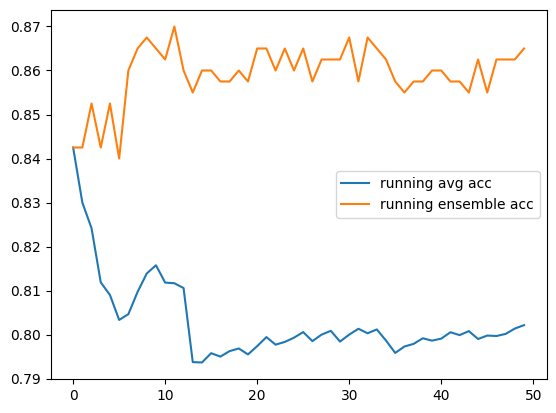

In [14]:
plt.plot(running_avg_acc, label="running avg acc")
plt.plot(running_ensemble_acc, label="running ensemble acc")
plt.legend()